
# Clasificador de alfabetización en salud: lenguaje técnico vs. lenguaje sencillo (PLS)

**Qué hace este cuaderno**
- Carga archivos `.txt` sin procesar desde el repositorio *Bridging the Gap in Health Literacy*
- Crea un conjunto de datos tabulares con métricas de legibilidad y características de longitud/razón
- Realiza **selección de características no paramétricas** (KS + U de Mann-Whitney con α = 0,0008, umbral estricto similar al de Bonferroni)
- Entrena clasificadores **Random Forest** y **Gradient Boosting**
- Registra ejecuciones en **MLflow**
- Produce **curvas ROC/PR**, **matrices de confusión** y gráficos de **20 características principales de importancia**


## 1) Clonar repositorio e instalar paquetes

In [1]:

# Clonar el repositorio del conjunto de datos
%cd /content
!git clone https://github.com/feliperussi/bridging-the-gap-in-health-literacy.git

# Instalar dependencias
!pip -q install numpy pandas scipy scikit-learn textstat nltk mlflow pyyaml joblib


/content
Cloning into 'bridging-the-gap-in-health-literacy'...
remote: Enumerating objects: 72074, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 72074 (delta 0), reused 2 (delta 0), pack-reused 72071 (from 2)
Receiving objects: 100% (72074/72074), 315.90 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (2991/2991), done.
Updating files: 100% (87209/87209), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

## 2) Descargar recursos NLTK (tokenizadores)

In [2]:

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 3) Configuración

In [3]:
DEFAULT_CFG = {
    "data": {
        "source_root": "/content/bridging-the-gap-in-health-literacy/data_collection_and_processing/Data Sources",
        # Carpeta de mapas -> etiqueta binaria
        "label_mapping": {
            "ClinicalTrials.gov": "TECH",
            "Cochrane":          "TECH",
            "Pfizer":            "PLS",
            "Trial Summaries":   "PLS"
        },
        "subdirs": ["train", "test"],
        "pattern": "*.txt",
        "id_from_filename": True
    },
    "stats": {
        "alpha": 0.0008,  # umbral estricto ~ Bonferroni para ~64 métricas
        "use_wilcoxon_if_paired": False,
        "pair_id_col": None
    },
    "features": {
        "exclude_cols": ["text", "label", "source", "filepath", "doc_id"]
    },
    "models": {
        "random_forest": {
            "n_estimators": 500,
            "max_depth": None,
            "min_samples_leaf": 2,
            "max_features": "sqrt",
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1
        },
        "gradient_boosting": {
            "n_estimators": 300,
            "learning_rate": 0.05,
            "max_depth": 3,
            "subsample": 0.8,
            "random_state": 42
        }
    },
    "mlflow": {
        "enable": True,
        "experiment_name": "healthlit-entrega2"
    },
    "outputs": {
        "dir": "/content/healthlit_outputs"
    }
}


## 4) Crear un conjunto de datos, seleccionar características y entrenar modelos

In [4]:

%%writefile /content/run_healthlit_cls.py
import os, glob, sys, yaml, joblib
import numpy as np, pandas as pd
from pathlib import Path
from typing import List, Dict
from itertools import product
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, matthews_corrcoef)
from sklearn.inspection import permutation_importance

import textstat
from nltk.tokenize import sent_tokenize, word_tokenize

def list_txts(root: str, subdirs: List[str], pattern: str) -> List[str]:
    files = []
    for sd in subdirs:
        base = os.path.join(root, sd)
        files.extend(glob.glob(os.path.join(base, "**", pattern), recursive=True))
    return sorted(files)

def read_text(path: str) -> str:
    try:
        with open(path, "r", encoding="utf-8") as f:
            return f.read()
    except UnicodeDecodeError:
        with open(path, "r", encoding="latin-1") as f:
            return f.read()

def basic_counts(text: str) -> Dict[str, float]:
    sents = sent_tokenize(text)
    words = word_tokenize(text)
    chars = len(text)
    n_sents = max(len(sents),1)
    tokens_alpha = [w for w in words if w.isalpha()]
    n_words = len(tokens_alpha)
    n_tokens = len(words)
    vocab = {w.lower() for w in tokens_alpha}
    n_vocab = len(vocab)
    avg_wlen = np.mean([len(w) for w in tokens_alpha]) if n_words>0 else 0
    digits = sum(ch.isdigit() for ch in text)
    uppers = sum(ch.isupper() for ch in text)
    puncts = sum(1 for ch in text if ch in ".,;:!?-—()[]{}\"'")
    return {
        "n_chars": chars,
        "n_tokens": n_tokens,
        "n_words": n_words,
        "n_sents": n_sents,
        "type_token_ratio": n_vocab / n_words if n_words>0 else 0,
        "avg_word_len": avg_wlen,
        "avg_sent_len_words": n_words / n_sents if n_sents>0 else 0,
        "pct_digits": digits / max(chars,1),
        "pct_upper": uppers / max(chars,1),
        "pct_punct": puncts / max(chars,1)
    }

def readability(text: str) -> Dict[str, float]:
    def safe(fn, default=np.nan):
        try: return fn()
        except: return default
    return {
        "flesch_reading_ease":  safe(lambda: textstat.flesch_reading_ease(text)),
        "flesch_kincaid_grade": safe(lambda: textstat.flesch_kincaid_grade(text)),
        "gunning_fog":          safe(lambda: textstat.gunning_fog(text)),
        "smog_index":           safe(lambda: textstat.smog_index(text)),
        "coleman_liau_index":   safe(lambda: textstat.coleman_liau_index(text)),
        "dale_chall_score":     safe(lambda: textstat.dale_chall_readability_score(text)),
    }

def cliffs_delta(x, y):
    gt = sum(a > b for a,b in product(x, y))
    lt = sum(a < b for a,b in product(x, y))
    return (gt - lt) / (len(x)*len(y))

def build_dataset(cfg: dict) -> pd.DataFrame:
    root = cfg["data"]["source_root"]
    mapping = cfg["data"]["label_mapping"]
    subdirs = cfg["data"]["subdirs"]
    pattern = cfg["data"]["pattern"]
    out_dir = cfg["outputs"]["dir"]
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    rows = []
    for source_folder, label in mapping.items():
        folder = os.path.join(root, source_folder)
        if not os.path.isdir(folder):
            print(f"[WARN] Missing folder: {folder}")
            continue
        files = list_txts(folder, subdirs, pattern)
        print(f"[INFO] {source_folder}: {len(files)} .txt files")
        for fp in files:
            text = read_text(fp)
            bc = basic_counts(text)
            rd = readability(text)
            row = {"filepath": fp, "source": source_folder, "label": label, "text": text}
            row.update(bc); row.update(rd)
            if cfg["data"].get("id_from_filename", True):
                row["doc_id"] = os.path.basename(fp)
            rows.append(row)

    df = pd.DataFrame(rows)
    csv_out = os.path.join(out_dir, "docs_features_raw.csv")
    df.to_csv(csv_out, index=False)
    print(f"[OK] Saved: {csv_out}")
    return df

def select_features(df: pd.DataFrame, cfg: dict):
    label_col = "label"
    alpha = float(cfg["stats"]["alpha"])
    exclude = set(cfg["features"]["exclude_cols"])
    num_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    pls  = df[df[label_col]=='PLS']
    tech = df[df[label_col]=='TECH']

    rows=[]
    for f in num_cols:
        x = pls[f].dropna().values
        y = tech[f].dropna().values
        ks_stat, ks_p = stats.ks_2samp(x, y, alternative='two-sided', mode='auto')
        mw_u, mw_p    = stats.mannwhitneyu(x, y, alternative='two-sided', method='asymptotic')
        delta   = cliffs_delta(x, y) if len(x)*len(y)>0 else np.nan
        meddiff = (np.median(x)-np.median(y)) if (len(x)>0 and len(y)>0) else np.nan
        selected = (ks_p < alpha) and (mw_p < alpha)
        rows.append({"feature": f, "ks_p": ks_p, "mw_p": mw_p,
                     "cliffs_delta": delta, "median_diff": meddiff, "selected": selected})

    table = pd.DataFrame(rows).sort_values(['selected','ks_p','mw_p'], ascending=[False, True, True])
    selected_feats = table[table['selected']].feature.tolist()

    out_dir = cfg["outputs"]["dir"]
    table.to_csv(os.path.join(out_dir,"feature_tests_results.csv"), index=False)
    with open(os.path.join(out_dir,"selected_features.txt"),"w") as f:
        for s in selected_feats: f.write(s+"\n")

    print(f"[OK] Feature selection: {len(selected_feats)} selected / {len(num_cols)} candidates")
    return selected_feats, table

def train_and_eval(df: pd.DataFrame, selected_features, cfg: dict):
    label_col = "label"
    out_dir = cfg["outputs"]["dir"]
    X = df[selected_features].values
    y = (df[label_col]=='PLS').astype(int).values  # 1=PLS (non-technical), 0=TECH

    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    rf = RandomForestClassifier(**cfg["models"]["random_forest"])
    gb = GradientBoostingClassifier(**cfg["models"]["gradient_boosting"])

    results = {}
    for name, clf in [("RandomForest", rf), ("GradientBoosting", gb)]:
        clf.fit(Xtr, ytr)
        p = clf.predict(Xva)
        ps = clf.predict_proba(Xva)[:,1] if hasattr(clf,"predict_proba") else clf.decision_function(Xva)
        metrics = {
            "accuracy": float(accuracy_score(yva, p)),
            "f1_macro": float(f1_score(yva, p, average='macro')),
            "roc_auc": float(roc_auc_score(yva, ps)),
            "pr_auc": float(average_precision_score(yva, ps)),
            "mcc": float(matthews_corrcoef(yva, p))
        }
        # Importance
        if hasattr(clf, "feature_importances_"):
            imp = pd.Series(clf.feature_importances_, index=selected_features).sort_values(ascending=False)
        else:
            pi = permutation_importance(clf, Xva, yva, n_repeats=10, random_state=42).importances_mean
            imp = pd.Series(pi, index=selected_features).sort_values(ascending=False)

        imp.to_csv(os.path.join(out_dir, f"{name}_importances.csv"))
        pd.DataFrame([metrics]).to_csv(os.path.join(out_dir, f"{name}_metrics_val.csv"), index=False)
        joblib.dump(clf, os.path.join(out_dir, f"{name}.joblib"))
        results[name] = metrics
        print(f"[OK] {name} ->", metrics)

        # MLflow
        if cfg["mlflow"].get("enable", True):
            try:
                import mlflow, mlflow.sklearn
                mlflow.set_experiment(cfg["mlflow"]["experiment_name"])
                with mlflow.start_run(run_name=name):
                    mlflow.log_params(clf.get_params())
                    for k,v in metrics.items(): mlflow.log_metric(k, v)
                    mlflow.log_artifact(os.path.join(out_dir, f"{name}_importances.csv"))
                    mlflow.sklearn.log_model(clf, artifact_path=f"{name}_model")
            except Exception as e:
                print("[WARN] MLflow not available:", e)

    pd.DataFrame(results).T.to_csv(os.path.join(out_dir, "model_metrics_val.csv"))
    return results

def main(DEFAULT_CFG):
    cfg = DEFAULT_CFG
    os.makedirs(cfg["outputs"]["dir"], exist_ok=True)
    df = build_dataset(cfg)
    selected, _ = select_features(df, cfg)
    results = train_and_eval(df, selected, cfg)
    print("\n=== Summary ===")
    print(pd.DataFrame(results).T)

if __name__ == "__main__":

    import json
    with open("/content/DEFAULT_CFG.json","r") as f:
        DC = json.load(f)
    main(DC)


Writing /content/run_healthlit_cls.py


In [5]:

import json, os
os.makedirs("/content/healthlit_outputs", exist_ok=True)
with open("/content/DEFAULT_CFG.json","w") as f:
    json.dump(DEFAULT_CFG, f)

!python /content/run_healthlit_cls.py


[INFO] ClinicalTrials.gov: 751 .txt files
[INFO] Cochrane: 58963 .txt files
[INFO] Pfizer: 606 .txt files
[INFO] Trial Summaries: 0 .txt files
[OK] Saved: /content/healthlit_outputs/docs_features_raw.csv
[OK] Feature selection: 15 selected / 16 candidates
[OK] RandomForest -> {'accuracy': 0.9946120689655172, 'f1_macro': 0.83366730958952, 'roc_auc': 0.9927019042933273, 'pr_auc': 0.7693333691204262, 'mcc': 0.6858997094489407}
2025/09/08 00:58:40 INFO mlflow.tracking.fluent: Experiment with name 'healthlit-entrega2' does not exist. Creating a new experiment.
2025/09/08 00:58:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/08 00:58:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[OK] GradientBoosting -> {'accuracy': 0.9941976127320955, 'f1_macro': 0.8199660944103532, 'roc_auc': 0.9884042867532625, 'pr_auc': 0.72

## 5) Visualizaciones (ROC, PR, matriz de confusión, 20 principales)

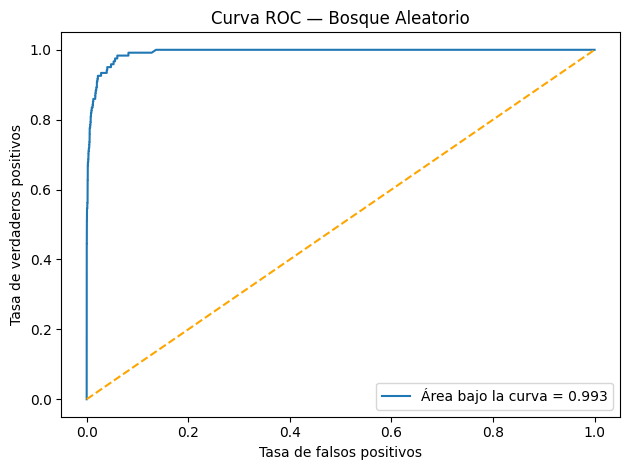

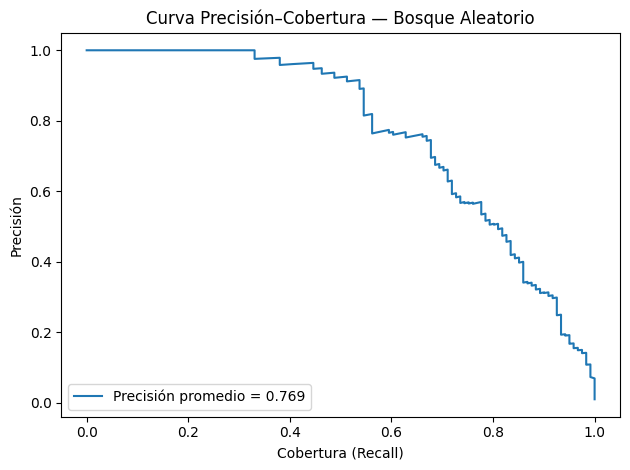

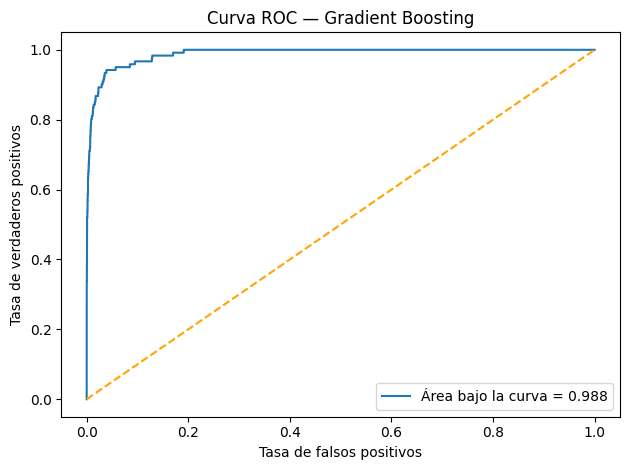

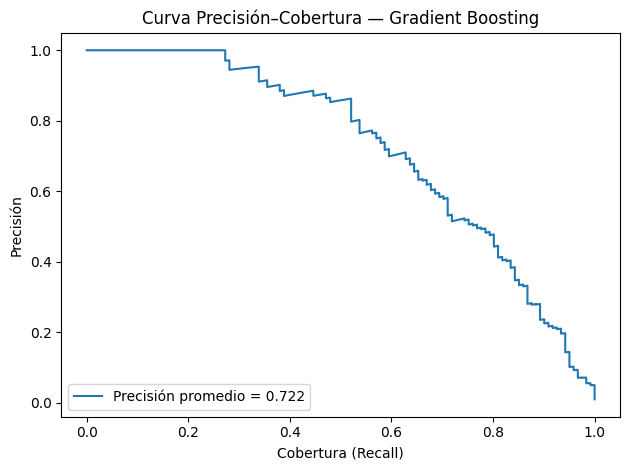

<Figure size 640x480 with 0 Axes>

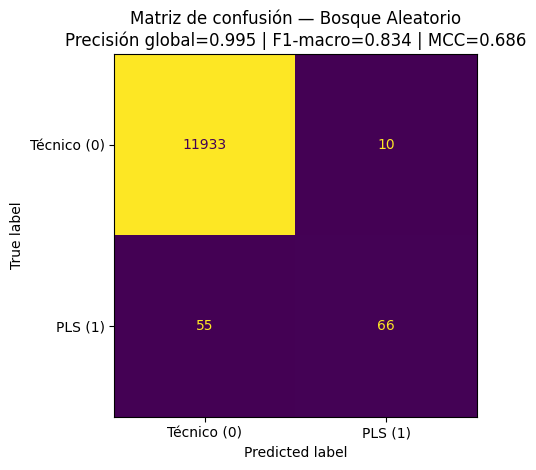

<Figure size 640x480 with 0 Axes>

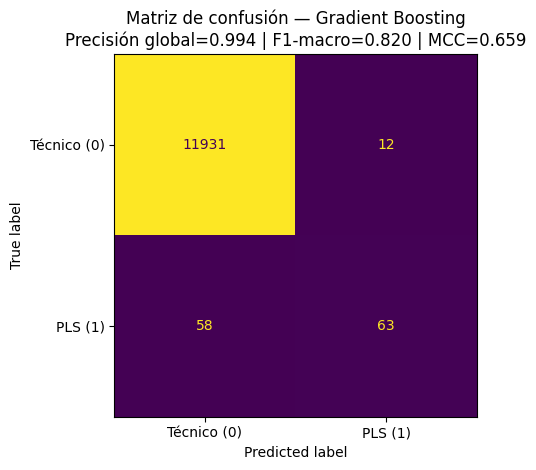

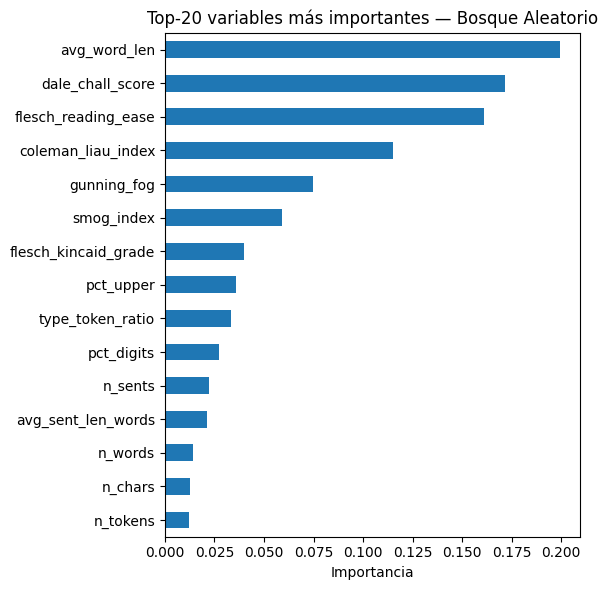

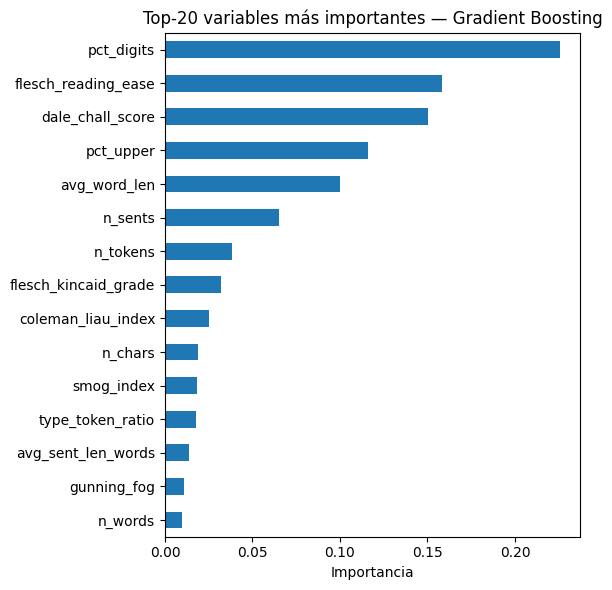

Gráficas guardadas en: /content/healthlit_outputs


In [6]:
import os, joblib, yaml
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, precision_recall_curve, confusion_matrix,
                             accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, average_precision_score)
import matplotlib.pyplot as plt

OUT = "/content/healthlit_outputs"

# Cargar datos y funciones seleccionadas
df = pd.read_csv(f"{OUT}/docs_features_raw.csv")
with open(f"{OUT}/selected_features.txt") as f:
    selected = [l.strip() for l in f if l.strip()]

X = df[selected].values
y = (df["label"]=="PLS").astype(int).values

Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = joblib.load(f"{OUT}/RandomForest.joblib")
gb = joblib.load(f"{OUT}/GradientBoosting.joblib")
models = {"Bosque Aleatorio": rf, "Gradient Boosting": gb}

# Curvas ROC y PR
for nombre, modelo in models.items():
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(Xva)[:,1]
    else:
        y_score = modelo.decision_function(Xva)

    # ROC
    fpr, tpr, _ = roc_curve(yva, y_score)
    auc = roc_auc_score(yva, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Área bajo la curva = {auc:.3f}")
    plt.plot([0,1],[0,1],"--", color="orange")
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.title(f"Curva ROC — {nombre}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"{OUT}/{nombre}_ROC.png", dpi=150)
    plt.show()

    # PR
    precision, recall, _ = precision_recall_curve(yva, y_score)
    ap = average_precision_score(yva, y_score)
    plt.figure()
    plt.plot(recall, precision, label=f"Precisión promedio = {ap:.3f}")
    plt.xlabel("Cobertura (Recall)")
    plt.ylabel("Precisión")
    plt.title(f"Curva Precisión–Cobertura — {nombre}")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(f"{OUT}/{nombre}_PR.png", dpi=150)
    plt.show()

# Matrices de confusión + métricas de validación
from sklearn.metrics import ConfusionMatrixDisplay
for nombre, modelo in models.items():
    y_pred = modelo.predict(Xva)
    cm = confusion_matrix(yva, y_pred)
    acc = accuracy_score(yva, y_pred)
    f1m = f1_score(yva, y_pred, average="macro")
    mcc = matthews_corrcoef(yva, y_pred)

    disp = ConfusionMatrixDisplay(cm, display_labels=["Técnico (0)", "PLS (1)"])
    plt.figure()
    disp.plot(values_format="d", colorbar=False)
    plt.title(f"Matriz de confusión — {nombre}\nPrecisión global={acc:.3f} | F1-macro={f1m:.3f} | MCC={mcc:.3f}")
    plt.tight_layout()
    plt.savefig(f"{OUT}/{nombre}_matriz_confusion.png", dpi=150)
    plt.show()

# Importancia de variables (Top-20)
from sklearn.inspection import permutation_importance
for nombre, modelo in models.items():
    if hasattr(modelo, "feature_importances_"):
        imp = pd.Series(modelo.feature_importances_, index=selected).sort_values(ascending=False)
    else:
        pi = permutation_importance(modelo, Xva, yva, n_repeats=10, random_state=42).importances_mean
        imp = pd.Series(pi, index=selected).sort_values(ascending=False)
    top = imp.head(20)
    ax = top[::-1].plot(kind="barh", figsize=(6,6))
    ax.set_xlabel("Importancia")
    ax.set_title(f"Top-20 variables más importantes — {nombre}")
    plt.tight_layout()
    plt.savefig(f"{OUT}/{nombre}_importancias_top20.png", dpi=150)
    plt.show()

print("Gráficas guardadas en:", OUT)


## 6) Descripción general de métricas

In [7]:

import pandas as pd, glob, os
out = "/content/healthlit_outputs"
print("\n".join(sorted(glob.glob(os.path.join(out, "*")))))
display(pd.read_csv(os.path.join(out, "model_metrics_val.csv")))


/content/healthlit_outputs/Bosque Aleatorio_PR.png
/content/healthlit_outputs/Bosque Aleatorio_ROC.png
/content/healthlit_outputs/Bosque Aleatorio_importancias_top20.png
/content/healthlit_outputs/Bosque Aleatorio_matriz_confusion.png
/content/healthlit_outputs/Gradient Boosting_PR.png
/content/healthlit_outputs/Gradient Boosting_ROC.png
/content/healthlit_outputs/Gradient Boosting_importancias_top20.png
/content/healthlit_outputs/Gradient Boosting_matriz_confusion.png
/content/healthlit_outputs/GradientBoosting.joblib
/content/healthlit_outputs/GradientBoosting_importances.csv
/content/healthlit_outputs/GradientBoosting_metrics_val.csv
/content/healthlit_outputs/RandomForest.joblib
/content/healthlit_outputs/RandomForest_importances.csv
/content/healthlit_outputs/RandomForest_metrics_val.csv
/content/healthlit_outputs/docs_features_raw.csv
/content/healthlit_outputs/feature_tests_results.csv
/content/healthlit_outputs/model_metrics_val.csv
/content/healthlit_outputs/selected_features.

,Unnamed: 0,accuracy,f1_macro,roc_auc,pr_auc,mcc
0,RandomForest,0.994612,0.833667,0.992702,0.769333,0.685900
1,GradientBoosting,0.994198,0.819966,0.988404,0.722104,0.658785


## 7) Validación con textos

In [8]:
REPO_PATH = "/content/bridging-the-gap-in-health-literacy"
OUT = "/content/healthlit_outputs"

df_complete = pd.read_csv(f"{OUT}/docs_features_raw.csv")

test_data = df_complete[df_complete['filepath'].str.contains('/test/')].copy()

print(f"datos de TEST: {len(test_data)} documentos")
print(f"Distribución por fuente:")
for source in test_data['source'].value_counts().items():
    print(f"     - {source[0]}: {source[1]} documentos")

datos de TEST: 11849 documentos
Distribución por fuente:
     - Cochrane: 11604 documentos
     - ClinicalTrials.gov: 129 documentos
     - Pfizer: 116 documentos


2. CARGAR MODELOS REALES Y HACER PREDICCIONES

In [9]:
try:
    rf_model = joblib.load(f"{OUT}/RandomForest.joblib")
    gb_model = joblib.load(f"{OUT}/GradientBoosting.joblib")
except Exception as e:
    print(f"Error cargando modelos {e}")
    raise

try:
    with open(f"{OUT}/selected_features.txt") as f:
        selected_features = [l.strip() for l in f if l.strip()]
except Exception as e:
    print(f"Eror cargando caractersticas: {e}")
    raise

X_test = test_data[selected_features].fillna(0).values
y_test_true = (test_data['label'] == 'PLS').astype(int).values

rf_prob_pls = rf_model.predict_proba(X_test)[:, 1]
rf_predictions = ['PLS' if prob > 0.5 else 'TECH' for prob in rf_prob_pls]

gb_prob_pls = gb_model.predict_proba(X_test)[:, 1]
gb_predictions = ['PLS' if prob > 0.5 else 'TECH' for prob in gb_prob_pls]

results_df = test_data.copy()
results_df['rf_prob_pls'] = rf_prob_pls
results_df['rf_prediction'] = rf_predictions
results_df['gb_prob_pls'] = gb_prob_pls
results_df['gb_prediction'] = gb_predictions
results_df['true_label'] = results_df['label']

3. ANÁLISIS DE PRECISIÓN CON ETIQUETAS VERDADERAS

In [10]:
print("ANÁLISIS")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_pred_binary = (rf_prob_pls > 0.5).astype(int)
gb_pred_binary = (gb_prob_pls > 0.5).astype(int)

rf_accuracy = accuracy_score(y_test_true, rf_pred_binary)
gb_accuracy = accuracy_score(y_test_true, gb_pred_binary)

source_results = {}
for source in results_df['source'].unique():
    source_data = results_df[results_df['source'] == source]
    source_true = (source_data['label'] == 'PLS').astype(int)
    source_rf_pred = (source_data['rf_prob_pls'] > 0.5).astype(int)

    accuracy = accuracy_score(source_true, source_rf_pred)
    avg_prob_pls = source_data['rf_prob_pls'].mean()

    source_results[source] = {
        'count': len(source_data),
        'accuracy': accuracy,
        'avg_prob_pls': avg_prob_pls,
        'expected_label': 'PLS' if source in ['Pfizer', 'Trial Summaries'] else 'TECH'
    }

    print(f"Etiqueta 1: {source_results[source]['expected_label']}")
    print(f"Precison: {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"PLS avg: {avg_prob_pls:.3f}")

ANÁLISIS
Etiqueta 1: TECH
Precison: 1.000 (100.0%)
PLS avg: 0.015
Etiqueta 1: TECH
Precison: 1.000 (100.0%)
PLS avg: 0.003
Etiqueta 1: PLS
Precison: 0.931 (93.1%)
PLS avg: 0.777


4. VISUALIZACIONES CON DATOS REALES DE TEST

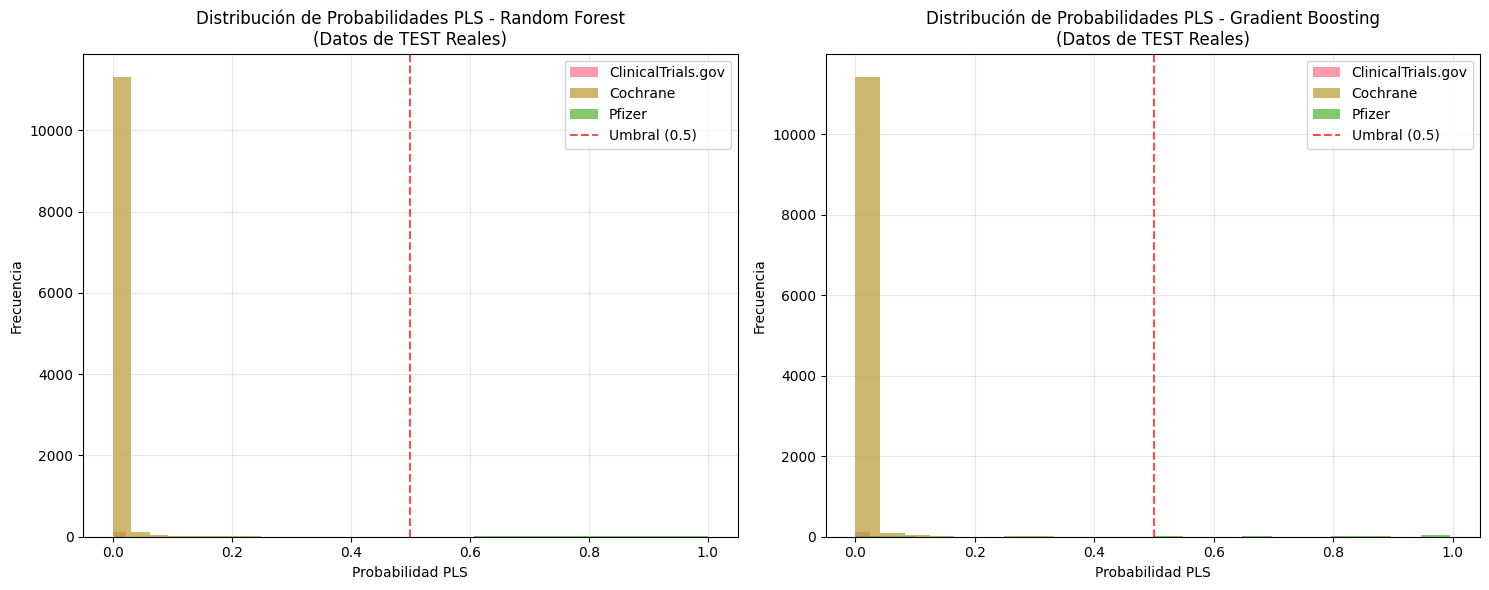

/tmp/ipython-input-3015247603.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(rf_probs_by_source, labels=sources, patch_artist=True)


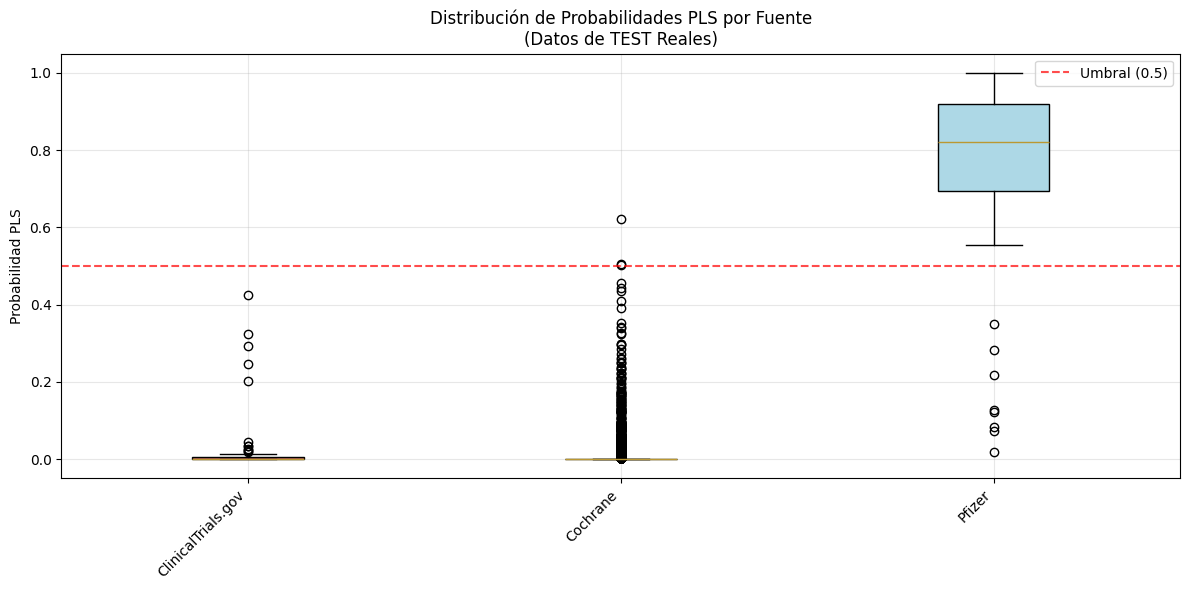

In [12]:
import seaborn as sns
plt.style.use('default')
sns.set_palette("husl")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for source in results_df['source'].unique():
    source_data = results_df[results_df['source'] == source]
    ax1.hist(source_data['rf_prob_pls'], alpha=0.7, label=source, bins=20)

ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral (0.5)')
ax1.set_xlabel('Probabilidad PLS')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Probabilidades PLS - Random Forest\n(Datos de TEST Reales)')
ax1.legend()
ax1.grid(True, alpha=0.3)

for source in results_df['source'].unique():
    source_data = results_df[results_df['source'] == source]
    ax2.hist(source_data['gb_prob_pls'], alpha=0.7, label=source, bins=20)

ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral (0.5)')
ax2.set_xlabel('Probabilidad PLS')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Probabilidades PLS - Gradient Boosting\n(Datos de TEST Reales)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sources = results_df['source'].unique()
rf_probs_by_source = [results_df[results_df['source'] == source]['rf_prob_pls'] for source in sources]

bp = ax.boxplot(rf_probs_by_source, labels=sources, patch_artist=True)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral (0.5)')
ax.set_ylabel('Probabilidad PLS')
ax.set_title('Distribución de Probabilidades PLS por Fuente\n(Datos de TEST Reales)')
ax.grid(True, alpha=0.3)
ax.legend()

colors = ['lightblue' if source in ['Pfizer', 'Trial Summaries'] else 'lightcoral' for source in sources]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


5. MATRIZ DE CONFUSIÓN

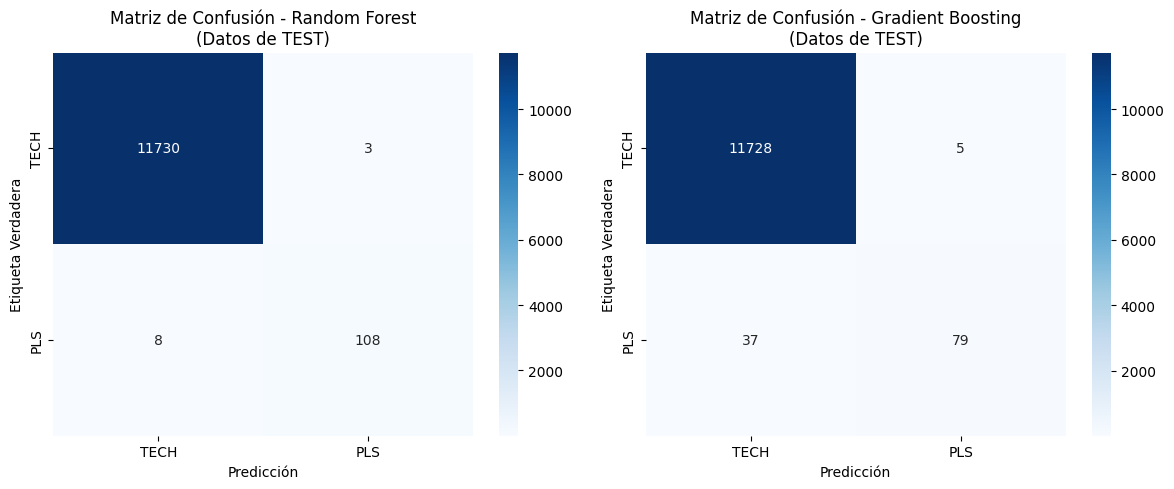

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_rf = confusion_matrix(y_test_true, rf_pred_binary)
cm_gb = confusion_matrix(y_test_true, gb_pred_binary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['TECH', 'PLS'], yticklabels=['TECH', 'PLS'])
ax1.set_title('Matriz de Confusión - Random Forest\n(Datos de TEST)')
ax1.set_xlabel('Predicción')
ax1.set_ylabel('Etiqueta Verdadera')

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['TECH', 'PLS'], yticklabels=['TECH', 'PLS'])
ax2.set_title('Matriz de Confusión - Gradient Boosting\n(Datos de TEST)')
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Etiqueta Verdadera')

plt.tight_layout()
plt.show()


6. REPORTE DETALLADO DE CLASIFICACIÓN

In [14]:

print("REPORTE")

print("RANDOM FOREST:")
print(classification_report(y_test_true, rf_pred_binary,
                          target_names=['TECH', 'PLS'], digits=3))

print("\n🔍 GRADIENT BOOSTING:")
print(classification_report(y_test_true, gb_pred_binary,
                          target_names=['TECH', 'PLS'], digits=3))

REPORTE
RANDOM FOREST:
              precision    recall  f1-score   support

        TECH      0.999     1.000     1.000     11733
         PLS      0.973     0.931     0.952       116

    accuracy                          0.999     11849
   macro avg      0.986     0.965     0.976     11849
weighted avg      0.999     0.999     0.999     11849


🔍 GRADIENT BOOSTING:
              precision    recall  f1-score   support

        TECH      0.997     1.000     0.998     11733
         PLS      0.940     0.681     0.790       116

    accuracy                          0.996     11849
   macro avg      0.969     0.840     0.894     11849
weighted avg      0.996     0.996     0.996     11849



7. CONCLUSIONES FINALES CON DATOS REALES DE TEST



In [15]:
print("CONCLUSIONES 1")

print(f"{len(test_data)} documentos de TEST del repositorio")
print(f"Precisión RF: {rf_accuracy*100:.1f}%")
print(f"Precisión GB: {gb_accuracy*100:.1f}%")
print(f"Fuentes validadas: {list(results_df['source'].unique())}")

print(f"ESTADÍSTICAS")
for source, stats in source_results.items():
    print(f"{source}: {stats['accuracy']*100:.1f}% precisión, {stats['count']} docs")

print(f"COHERENCIA")
coherence = np.corrcoef(rf_prob_pls, gb_prob_pls)[0,1]
print(f"Correlación RF vs GB: {coherence:.3f}")
print(f"Diferencia promedio: {np.mean(np.abs(rf_prob_pls - gb_prob_pls)):.3f}")

CONCLUSIONES 1
11849 documentos de TEST del repositorio
Precisión RF: 99.9%
Precisión GB: 99.6%
Fuentes validadas: ['ClinicalTrials.gov', 'Cochrane', 'Pfizer']
ESTADÍSTICAS
ClinicalTrials.gov: 100.0% precisión, 129 docs
Cochrane: 100.0% precisión, 11604 docs
Pfizer: 93.1% precisión, 116 docs
COHERENCIA
Correlación RF vs GB: 0.919
Diferencia promedio: 0.005


# 8) Automated Hyperparameter Tuning con GridSearchCV y K-Fold

In [16]:
import numpy as np
import pandas as pd
import joblib
import os
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
import time

 1. CARGAR DATOS Y CONFIGURACIÓN

In [17]:
OUT = "/content/healthlit_outputs"
df = pd.read_csv(f"{OUT}/docs_features_raw.csv")

with open(f"{OUT}/selected_features.txt") as f:
    selected_features = [l.strip() for l in f if l.strip()]

X = df[selected_features].fillna(0).values
y = (df["label"] == "PLS").astype(int).values

print(f"Datos cargados: {X.shape[0]} muestras, {X.shape[1]} características")
print(f"Distribución de clases: {np.bincount(y)}")

Datos cargados: 60320 muestras, 15 características
Distribución de clases: [59714   606]


 2. CONFIGURAR K-FOLD CROSS VALIDATION

In [18]:
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print(f"K-Fold CV configurado: {cv_folds.n_splits} folds estratificados")


K-Fold CV configurado: 3 folds estratificados


3. DEFINIR GRIDS DE HIPERPARÁMETROS

In [19]:

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Grid SIMPLE para Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

print("Grids de hiperparámetros definidos:")
print(f"Random Forest: {len(rf_param_grid)} parámetros")
print(f"Gradient Boosting: {len(gb_param_grid)} parámetros")


Grids de hiperparámetros definidos:
Random Forest: 4 parámetros
Gradient Boosting: 4 parámetros


4. CONFIGURAR SCORING

In [20]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

primary_scoring = 'roc_auc'

print(f"Scoring configurado: {list(scoring.keys())}")
print(f"Métrica principal: {primary_scoring}")


Scoring configurado: ['accuracy', 'f1', 'roc_auc']
Métrica principal: roc_auc


5. HYPERPARAMETER TUNING - RANDOM FOREST

In [21]:
print("TUNING RANDOM FOREST")

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    scoring=scoring,
    refit=primary_scoring,
    cv=cv_folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
rf_grid_search.fit(X, y)
rf_tuning_time = time.time() - start_time

print(f"Random Forest tuning completado en {rf_tuning_time:.1f} segundos")
print(f"Mejor score ({primary_scoring}): {rf_grid_search.best_score_:.4f}")
print(f"Mejores parámetros:")
for param, value in rf_grid_search.best_params_.items():
    print(f"   • {param}: {value}")

TUNING RANDOM FOREST
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Random Forest tuning completado en 248.7 segundos
Mejor score (roc_auc): 0.9006
Mejores parámetros:
   • class_weight: balanced
   • max_depth: 10
   • min_samples_split: 2
   • n_estimators: 200


6. HYPERPARAMETER TUNING - GRADIENT BOOSTING

In [22]:

gb_base = GradientBoostingClassifier(random_state=42)

gb_grid_search = GridSearchCV(
    estimator=gb_base,
    param_grid=gb_param_grid,
    scoring=scoring,
    refit=primary_scoring,
    cv=cv_folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
gb_grid_search.fit(X, y)
gb_tuning_time = time.time() - start_time

print(f"Gradient Boosting tuning completado en {gb_tuning_time:.1f} segundos")
print(f"Mejor score ({primary_scoring}): {gb_grid_search.best_score_:.4f}")
print(f"Mejores parámetros:")


for param, value in gb_grid_search.best_params_.items():
    print(f"   • {param}: {value}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Gradient Boosting tuning completado en 2175.8 segundos
Mejor score (roc_auc): 0.7581
Mejores parámetros:
   • learning_rate: 0.1
   • max_depth: 5
   • n_estimators: 200
   • subsample: 1.0


 7. COMPARAR RESULTADOS

In [23]:
results_comparison = pd.DataFrame({
    'Modelo': ['Random Forest', 'Gradient Boosting'],
    'Mejor_Score': [rf_grid_search.best_score_, gb_grid_search.best_score_],
    'Tiempo_Tuning': [rf_tuning_time, gb_tuning_time],
    'Mejores_Params': [str(rf_grid_search.best_params_), str(gb_grid_search.best_params_)]
})

print(results_comparison.to_string(index=False))

if rf_grid_search.best_score_ > gb_grid_search.best_score_:
    best_model = rf_grid_search.best_estimator_
    best_model_name = "Random Forest"
    best_score = rf_grid_search.best_score_
else:
    best_model = gb_grid_search.best_estimator_
    best_model_name = "Gradient Boosting"
    best_score = gb_grid_search.best_score_

print(f"MEJOR MODELO: {best_model_name}")
print(f"Score: {best_score:.4f}")

           Modelo  Mejor_Score  Tiempo_Tuning                                                                             Mejores_Params
    Random Forest     0.900634     248.661884 {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Gradient Boosting     0.758096    2175.789091              {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
MEJOR MODELO: Random Forest
Score: 0.9006


8. EVALUACIÓN DEL MEJOR MODELO

In [24]:

if best_model_name == "Random Forest":
    cv_results = rf_grid_search.cv_results_
else:
    cv_results = gb_grid_search.cv_results_

top_5_indices = np.argsort(cv_results[f'mean_test_{primary_scoring}'])[-5:]

for i, idx in enumerate(reversed(top_5_indices)):
    score = cv_results[f'mean_test_{primary_scoring}'][idx]
    std = cv_results[f'std_test_{primary_scoring}'][idx]
    params = cv_results['params'][idx]

    print(f"\n{i+1}. Score: {score:.4f} (±{std:.4f})")
    for param, value in params.items():
        print(f"   {param}: {value}")


1. Score: 0.9006 (±0.0109)
   class_weight: balanced
   max_depth: 10
   min_samples_split: 2
   n_estimators: 200

2. Score: 0.8995 (±0.0107)
   class_weight: balanced
   max_depth: 10
   min_samples_split: 2
   n_estimators: 100

3. Score: 0.8991 (±0.0077)
   class_weight: balanced
   max_depth: 10
   min_samples_split: 5
   n_estimators: 200

4. Score: 0.8983 (±0.0128)
   class_weight: balanced
   max_depth: 10
   min_samples_split: 5
   n_estimators: 100

5. Score: 0.7505 (±0.0099)
   class_weight: balanced
   max_depth: None
   min_samples_split: 5
   n_estimators: 200


9. GUARDAR MODELOS OPTIMIZADOS

In [25]:

optimized_dir = f"{OUT}/optimized_models"
os.makedirs(optimized_dir, exist_ok=True)

joblib.dump(rf_grid_search.best_estimator_, f"{optimized_dir}/RandomForest_optimized.joblib")
joblib.dump(gb_grid_search.best_estimator_, f"{optimized_dir}/GradientBoosting_optimized.joblib")

rf_results_df = pd.DataFrame(rf_grid_search.cv_results_)
gb_results_df = pd.DataFrame(gb_grid_search.cv_results_)

rf_results_df.to_csv(f"{optimized_dir}/rf_tuning_results.csv", index=False)
gb_results_df.to_csv(f"{optimized_dir}/gb_tuning_results.csv", index=False)

with open(f"{optimized_dir}/best_params_rf.txt", "w") as f:
    for param, value in rf_grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

with open(f"{optimized_dir}/best_params_gb.txt", "w") as f:
    for param, value in gb_grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print(f"Modelos optimizados guardados en: {optimized_dir}")

Modelos optimizados guardados en: /content/healthlit_outputs/optimized_models


10. RESUMEN FINAL

In [26]:
print(f"HYPERPARAMETER TUNING")

print(f"TUNING")
print(f"Random Forest: {rf_grid_search.best_score_:.4f} score")
print(f"Gradient Boosting: {gb_grid_search.best_score_:.4f} score")
print(f"Mejor modelo: {best_model_name}")
print(f"Tiempo total: {rf_tuning_time + gb_tuning_time:.1f} segundos")

HYPERPARAMETER TUNING
TUNING
Random Forest: 0.9006 score
Gradient Boosting: 0.7581 score
Mejor modelo: Random Forest
Tiempo total: 2424.5 segundos
